In [ ]:
import polars as pl 
import sys
from pathlib import Path
import importlib
import matplotlib.pyplot as plt
import numpy as np 
import polars as pl 
import bioframe as bf # https://bioframe.readthedocs.io/en/latest/index.html
from collections import Counter

# Set the font family to Arial
# https://g.co/gemini/share/3898a74b2d77
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial'] # Add Arial to the sans-serif list

plt.rcParams.update({
    'font.size': 20,
})

REFERENCE_GENOME = "hg38"
TILE_SIZE = 1000
METH_READ_PHASED_DIR = Path('/scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.founder-phased.all-cpgs')
SAMPLE = '200081' 
BED_METH = f"{METH_READ_PHASED_DIR}/{SAMPLE}.dna-methylation.founder-phased.all_cpgs.bed"

REPO_DIR = Path("/scratch/ucgd/lustre-labs/quinlan/u6018199/tapestry")
sys.path.append(str(REPO_DIR / "src" / "util"))

DELTA_METH_THRESHOLD = 0.9 

pl.Config.set_tbl_rows(10) 

polars.config.Config

## Tile the genome 

In [10]:
import tile
importlib.reload(tile)
from tile import get_tiles 

DF_TILES = get_tiles(REFERENCE_GENOME, TILE_SIZE)
DF_TILES

chrom,start,end
str,i64,i64
"""chr1""",0,1000
"""chr1""",1000,2000
"""chr1""",2000,3000
"""chr1""",3000,4000
"""chr1""",4000,5000
…,…,…
"""chrM""",11000,12000
"""chrM""",12000,13000
"""chrM""",13000,14000


## [Single Sample] Fetch phased and unphased DNA methylation at all CpG sites in the reference and sample genome

In [11]:
import read_data
importlib.reload(read_data)
from read_data import read_tapestry

DF_METH = read_tapestry(BED_METH)
DF_METH

chrom,start,end,total_read_count,methylation_level_count,methylation_level_model,start_hap_map_block,end_hap_map_block,haplotype_concordance_in_hap_map_block,num_het_SNVs_in_hap_map_block,total_read_count_pat,total_read_count_mat,founder_haplotype_pat,founder_haplotype_mat,methylation_level_pat_count,methylation_level_mat_count,methylation_level_pat_model,methylation_level_mat_model,cpg_is_within_50bp_of_mismatch_site,cpg_overlaps_at_least_one_snv,snv_genotypes,cpg_is_allele_specific
str,i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,i64,str,str,f64,f64,f64,f64,bool,bool,str,bool
"""chr1""",10468,10470,13,0.769,0.868,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr1""",10470,10472,13,0.769,0.878,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr1""",10483,10485,13,0.923,0.929,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr1""",10488,10490,14,1.0,0.95,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr1""",10492,10494,13,1.0,0.964,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""chrY""",56887399,56887401,38,0.737,0.942,null,null,null,null,null,null,null,null,null,null,null,null,null,false,""".""",false
"""chrY""",56887579,56887581,38,0.895,0.945,null,null,null,null,null,null,null,null,null,null,null,null,null,false,""".""",false
"""chrY""",56887581,56887583,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false,""".""",false


## [Single Sample] Filter out allele-specific CpG sites as these can masqeurade as imprinted loci 

In [ ]:
# Notice the values of "0.0" for count-based methylation on one of the haplotypes in this filter: 
DF_METH.filter(pl.col('cpg_is_allele_specific'))

chrom,start,end,total_read_count,methylation_level_count,methylation_level_model,start_hap_map_block,end_hap_map_block,haplotype_concordance_in_hap_map_block,num_het_SNVs_in_hap_map_block,total_read_count_pat,total_read_count_mat,founder_haplotype_pat,founder_haplotype_mat,methylation_level_pat_count,methylation_level_mat_count,methylation_level_pat_model,methylation_level_mat_model,cpg_is_within_50bp_of_mismatch_site,cpg_overlaps_at_least_one_snv,snv_genotypes,cpg_is_allele_specific
str,i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,i64,str,str,f64,f64,f64,f64,bool,bool,str,bool
"""chr1""",504316,504318,48,0.458,0.477,492339,532812,1.0,16,18,27,"""B""","""I""",0.0,0.778,0.063,0.935,false,true,"""het""",true
"""chr1""",516229,516231,58,0.466,0.602,492339,532812,1.0,16,25,33,"""B""","""I""",0.0,0.818,0.049,0.926,false,true,"""het""",true
"""chr1""",516337,516339,58,0.345,0.533,492339,532812,1.0,16,25,33,"""B""","""I""",0.8,0.0,0.934,0.057,false,true,"""het""",true
"""chr1""",699537,699539,45,0.311,0.457,593123,1314109,0.993119,436,19,16,"""B""","""I""",0.737,0.0,0.932,0.057,false,true,"""het""",true
"""chr1""",700917,700919,43,0.233,0.267,593123,1314109,0.993119,436,19,14,"""B""","""I""",0.526,0.0,0.67,0.055,false,true,"""het""",true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""chrX""",154952820,154952822,39,0.41,0.43,154941725,154993498,1.0,3,17,22,"""A""","""K""",0.0,0.727,0.06,0.88,false,true,"""het""",true
"""chrX""",154993497,154993499,26,0.231,0.243,154941725,154993498,1.0,3,12,14,"""A""","""K""",0.0,0.429,0.051,0.418,false,true,"""het""",true
"""chrX""",155443918,155443920,36,0.111,0.071,155370893,155485214,1.0,2,19,17,"""A""","""K""",0.0,0.235,0.06,0.137,false,true,"""het""",true


In [14]:
DF_METH_FREE_FROM_ALLELE_SPECIFIC_CPGS = DF_METH.filter(~pl.col('cpg_is_allele_specific'))
DF_METH_FREE_FROM_ALLELE_SPECIFIC_CPGS

chrom,start,end,total_read_count,methylation_level_count,methylation_level_model,start_hap_map_block,end_hap_map_block,haplotype_concordance_in_hap_map_block,num_het_SNVs_in_hap_map_block,total_read_count_pat,total_read_count_mat,founder_haplotype_pat,founder_haplotype_mat,methylation_level_pat_count,methylation_level_mat_count,methylation_level_pat_model,methylation_level_mat_model,cpg_is_within_50bp_of_mismatch_site,cpg_overlaps_at_least_one_snv,snv_genotypes,cpg_is_allele_specific
str,i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,i64,str,str,f64,f64,f64,f64,bool,bool,str,bool
"""chr1""",10468,10470,13,0.769,0.868,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr1""",10470,10472,13,0.769,0.878,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr1""",10483,10485,13,0.923,0.929,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr1""",10488,10490,14,1.0,0.95,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr1""",10492,10494,13,1.0,0.964,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""chrY""",56887399,56887401,38,0.737,0.942,null,null,null,null,null,null,null,null,null,null,null,null,null,false,""".""",false
"""chrY""",56887579,56887581,38,0.895,0.945,null,null,null,null,null,null,null,null,null,null,null,null,null,false,""".""",false
"""chrY""",56887581,56887583,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false,""".""",false


## [Single Sample] Compute difference in methylation between haplotypes in tiles

In [37]:
import methylation
importlib.reload(methylation)
from methylation import compute_methylation

DF_TILES_WITH_METH = compute_methylation(DF_TILES, DF_METH_FREE_FROM_ALLELE_SPECIFIC_CPGS)
DF_TILES_WITH_METH

chrom,start,end,num_cpgs,founder_pat,founder_mat,count_based_meth,model_based_meth,count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,model_based_meth_mat
str,i64,i64,u32,list[str],list[str],f64,f64,f64,f64,f64,f64
"""chr1""",10000,11000,93,[null],[null],0.724176,0.768044,null,null,null,null
"""chr1""",11000,12000,49,[null],[null],0.700417,0.787375,null,null,null,null
"""chr1""",12000,13000,22,[null],[null],0.75381,0.841857,null,null,null,null
"""chr1""",13000,14000,16,[null],[null],0.537933,0.628267,null,null,null,null
"""chr1""",14000,15000,25,[null],[null],0.759708,0.852542,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…
"""chrY""",56883000,56884000,7,[null],[null],0.6222,0.7446,null,null,null,null
"""chrY""",56884000,56885000,12,[null],[null],0.7378,0.846,null,null,null,null
"""chrY""",56885000,56886000,14,[null],[null],0.755846,0.856923,null,null,null,null


Text(0, 0.5, 'Number of tiles')

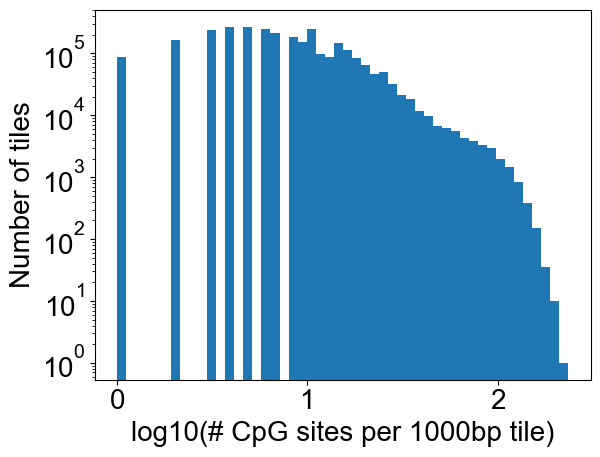

In [38]:
plt.hist(
    np.log10(DF_TILES_WITH_METH["num_cpgs"]), 
    bins=50, # type: ignore
    alpha=None, 
    label=None,
    color=None
)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel(f'log10(# CpG sites per {TILE_SIZE}bp tile)')
plt.ylabel('Number of tiles')

In [39]:
DF_TILES_WITH_METH.filter(pl.col('count_based_meth_pat').is_not_null())

chrom,start,end,num_cpgs,founder_pat,founder_mat,count_based_meth,model_based_meth,count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,model_based_meth_mat
str,i64,i64,u32,list[str],list[str],f64,f64,f64,f64,f64,f64
"""chr1""",499000,500000,7,"[""B"", null]","[null, ""I""]",0.799667,0.933333,0.815,0.941667,0.851667,0.9385
"""chr1""",500000,501000,7,"[""B""]","[""I""]",0.748,0.890143,0.734857,0.908286,0.752143,0.855143
"""chr1""",501000,502000,6,"[""B"", null]","[null, ""I""]",0.734,0.887,0.806,0.95525,0.71025,0.83525
"""chr1""",502000,503000,9,"[""B""]","[""I""]",0.769111,0.904556,0.767,0.947667,0.762667,0.870556
"""chr1""",503000,504000,10,"[""B""]","[""I""]",0.8159,0.9336,0.8662,0.9469,0.799,0.9372
…,…,…,…,…,…,…,…,…,…,…,…
"""chrX""",155654000,155655000,1,"[""A""]","[""K""]",0.657,0.85,0.727,0.921,0.538,0.724
"""chrX""",155655000,155656000,6,"[""A"", null]","[null, ""K""]",0.6986,0.8356,0.796,0.9466,0.5536,0.6064
"""chrX""",155656000,155657000,6,"[""A""]","[""K""]",0.702167,0.8265,0.784333,0.946333,0.595,0.679667


In [41]:
import imprinting
importlib.reload(imprinting)
from imprinting import compute_delta_methylation

DF_TILES_WITH_DELTA_METH = compute_delta_methylation(DF_TILES_WITH_METH)
DF_TILES_WITH_DELTA_METH.filter(pl.col('delta_of_count_based_meth').is_not_null())

chrom,start,end,founder_pat,founder_mat,count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,model_based_meth_mat,delta_of_count_based_meth,delta_of_model_based_meth
str,i64,i64,list[str],list[str],f64,f64,f64,f64,f64,f64
"""chr1""",499000,500000,"[""B"", null]","[null, ""I""]",0.815,0.941667,0.851667,0.9385,-0.036667,0.003167
"""chr1""",500000,501000,"[""B""]","[""I""]",0.734857,0.908286,0.752143,0.855143,-0.017286,0.053143
"""chr1""",501000,502000,"[""B"", null]","[null, ""I""]",0.806,0.95525,0.71025,0.83525,0.09575,0.12
"""chr1""",502000,503000,"[""B""]","[""I""]",0.767,0.947667,0.762667,0.870556,0.004333,0.077111
"""chr1""",503000,504000,"[""B""]","[""I""]",0.8662,0.9469,0.799,0.9372,0.0672,0.0097
…,…,…,…,…,…,…,…,…,…,…
"""chrX""",155654000,155655000,"[""A""]","[""K""]",0.727,0.921,0.538,0.724,0.189,0.197
"""chrX""",155655000,155656000,"[""A"", null]","[null, ""K""]",0.796,0.9466,0.5536,0.6064,0.2424,0.3402
"""chrX""",155656000,155657000,"[""A""]","[""K""]",0.784333,0.946333,0.595,0.679667,0.189333,0.266667


## [All Samples] Compute difference of haplotype-specific methylations for all samples 

In [ ]:
# The following cell takes 25 mins to run for all samples
# [TESTING] 2 mins to run for 2 samples

In [48]:
import imprinting 
importlib.reload(imprinting)
from imprinting import compute_delta_methylation_all_samples

from write_data import write_dataframe_to_bed

DF_DELTA_METH_ALL_SAMPLES = compute_delta_methylation_all_samples(REFERENCE_GENOME, TILE_SIZE, METH_READ_PHASED_DIR)
write_dataframe_to_bed(DF_DELTA_METH_ALL_SAMPLES, 'delta_meth_all_samples.bed', source=globals()["__vsc_ipynb_file__"])

100%|██████████| 2/2 [01:49<00:00, 54.94s/it]


In [49]:
from read_data import read_dataframe_from_bed

def read_all_samples(bed): 
    df = read_dataframe_from_bed(bed)
    return (
        df
        .with_columns(
            pl.col(df.columns[3:]).cast(pl.Float64)
        )
    )

DF_DELTA_METH_ALL_SAMPLES = read_all_samples('delta_meth_all_samples.bed')
DF_DELTA_METH_ALL_SAMPLES.filter(pl.col('NA12877_count').is_not_null())

chrom,start,end,NA12877_count,NA12877_model,NA12878_count,NA12878_model
str,i64,i64,f64,f64,f64,f64
"""chr1""",689000,690000,-0.615,-0.6005,0.3785,0.4625
"""chr1""",690000,691000,0.15675,0.201875,-0.021857,-0.042857
"""chr1""",691000,692000,0.009,-0.004333,0.119,0.020333
"""chr1""",692000,693000,0.1378,0.2147,-0.029667,-0.036667
"""chr1""",693000,694000,0.046562,0.084937,-0.026813,-0.077
…,…,…,…,…,…,…
"""chr22""",50796000,50797000,0.0715,0.115,-0.0165,-0.089
"""chr22""",50797000,50798000,0.002417,-0.006583,-0.00125,0.011167
"""chr22""",50798000,50799000,-0.013176,-0.013235,0.023706,0.022235


## [All Samples] Find candidate imprinted loci

In [50]:
def filter_to_imprinted_loci(df, delta_meth_threshold):
    delta_meth_cols = [col for col in df.columns if col not in ['chrom', 'start', 'end']]
    df = df.filter(pl.any_horizontal(pl.col(delta_meth_cols).abs() > delta_meth_threshold))
    # abs_value_exprs = [pl.col(col).abs() for col in delta_meth_cols]
    # df = df.with_columns(max_abs_value = pl.max_horizontal(abs_value_exprs))    
    return df

DF_IMPRINTED_CANDIDATES = filter_to_imprinted_loci(DF_DELTA_METH_ALL_SAMPLES, DELTA_METH_THRESHOLD)
DF_IMPRINTED_CANDIDATES

chrom,start,end,NA12877_count,NA12877_model,NA12878_count,NA12878_model
str,i64,i64,f64,f64,f64,f64
"""chr1""",68050000,68051000,-0.663043,-0.908319,-0.621553,-0.867681
"""chr1""",146170000,146171000,-0.304,-0.411,-0.948,-0.893
"""chr1""",148603000,148604000,0.84,0.911,null,null
"""chr1""",189562000,189563000,-0.75,-0.88,0.844,0.91
"""chr1""",248649000,248650000,-0.123,-0.079333,0.929,0.917
…,…,…,…,…,…,…
"""chr19""",56839000,56840000,-0.657707,-0.906537,-0.633293,-0.882854
"""chr20""",31547000,31548000,-0.673561,-0.894122,-0.714146,-0.913902
"""chr20""",43514000,43515000,-0.635448,-0.892155,-0.629424,-0.910729


## [All samples] Compare candidate imprinted loci with a truth set

In [ ]:
# TODO: 
# continue from here on Mon 12/1

In [51]:
def read_truth_set_imprinted_loci(): 
    df = (
        pl
        # https://quinlangroup.slack.com/archives/C0803TM7X0X/p1758742312373849
        # https://www.tandfonline.com/doi/10.1080/15592294.2022.2091815
        .read_csv(
            't0001-10.1080_15592294.2022.2091815.csv', 
            separator=',',
            comment_prefix=None,
            has_header=True,
        )
        .with_columns(
            pl.col("Genomic Coordinates").str.split_exact(":", 1)  # Split by ":" into two parts
            .struct.rename_fields(["chrom", "start-end"])          
            .alias("split_colon")
        )
        .unnest("split_colon")
        .with_columns(
            pl.col("start-end").str.split_exact("-", 1) # Split by "-" into two parts
            .struct.rename_fields(["start", "end"])     
            .alias("split_dash")
        )
        .unnest("split_dash")
        .drop(["start-end", "Genomic Coordinates"])
        .with_columns(
            pl.col("Distance to Nearest Transcript")
            .str.replace_all(",", "")  # Step 1: Remove all commas
            .cast(pl.Int64)            # Step 2: Cast the cleaned string to i64
        )
        .cast({
            "start": pl.Int64,
            "end": pl.Int64,
        })
        .with_columns(
            (pl.col('end') - pl.col('start')).alias('length')
        )
    )

    return df.select(['chrom', 'start', 'end', 'length'] + df.columns[:-4])

DF_IMPRINTED_TRUTH = read_truth_set_imprinted_loci()
DF_IMPRINTED_TRUTH
# ICRs overlapping ENCODE annotated regions of CTCF binding and DNase I hypersensitivity are indicated by * and ^, respectively. 
# ICRs overlapping previously published ICRs of imprinted genes are indicated by #.

chrom,start,end,length,ID,Parental Origin of Methylation,Nearest Transcript,Distance to Nearest Transcript
str,i64,i64,i64,str,str,str,i64
"""chr1""",628959,630792,1833,"""ICR_2^""","""P""","""MTND1P23|MTND2P28""",0
"""chr1""",632183,632834,651,"""ICR_3^""","""P""","""MTCO1P12|MIR12136|MTCO2P12""",0
"""chr1""",633381,634921,1540,"""ICR_4^""","""P""","""MTCO2P12|MTATP8P1|MTATP6P1|MTC…",0
"""chr1""",1174554,1174597,43,"""ICR_6*""","""P""","""TTLL10""",0
"""chr1""",2469095,2469433,338,"""ICR_10^""","""P""","""PLCH2""",0
…,…,…,…,…,…,…,…
"""chrX""",40243438,40244131,693,"""ICR_1413^""","""P""","""BCOR""",66048
"""chrX""",47637837,47638168,331,"""ICR_1417*^""","""M""","""ELK1""",0
"""chrX""",99939597,99940400,803,"""ICR_1441^""","""M""","""B3GNT2P1""",51491


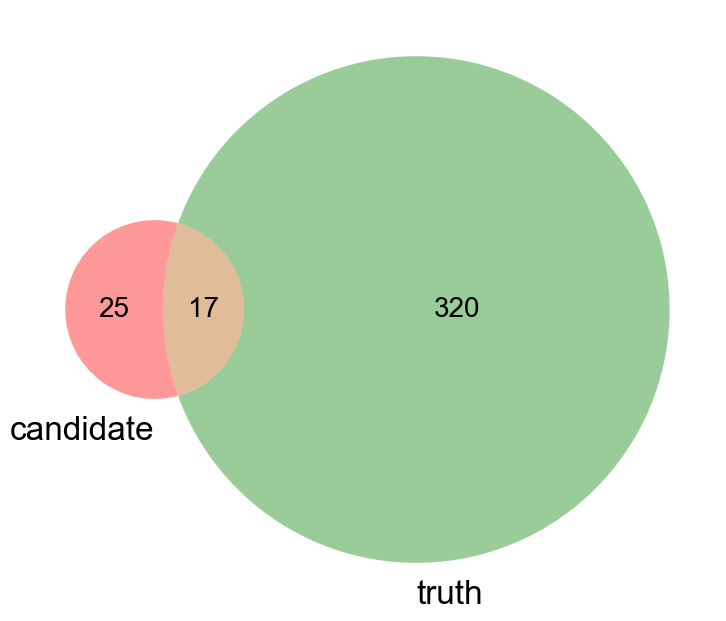

In [122]:
import find_unique_and_common_records
importlib.reload(find_unique_and_common_records)
from find_unique_and_common_records import find_unique_and_common_records_with_venn_diagram 

DF_IMPRINTED_CANDIDATES_UNIQUE, DF_IMPRINTED_TRUTH_UNIQUE, DF_IMPRINTED_COMMON = find_unique_and_common_records_with_venn_diagram(
    DF_IMPRINTED_CANDIDATES, 
    DF_IMPRINTED_TRUTH, 
    min_overlap=200, 
    labels=('candidate', 'truth')
)

In [121]:
# Almost all candidate loci that are found in the truth set are predicted to be methylated on maternal haplotype  
# "Previously reported ICRs that do not have gamete specific methylation are also included and labelled as having Somatic (S) methylation. "
Counter(DF_IMPRINTED_COMMON['Parental Origin of Methylation_2'].to_numpy())

Counter({'M': 16, 'S': 1})

In [ ]:
# Validated in IGV some of these: 
DF_IMPRINTED_COMMON

chrom,start,end,NA12877_count,NA12877_model,NA12878_count,NA12878_model,chrom_2,start_2,end_2,length_2,ID_2,Parental Origin of Methylation_2,Nearest Transcript_2,Distance to Nearest Transcript_2,overlap_len,locus_candidate
str,i64,i64,f64,f64,f64,f64,str,i64,i64,i64,str,str,str,i64,i64,str
"""chr1""",68050000,68051000,-0.663043,-0.908319,-0.621553,-0.867681,"""chr1""",68049858,68051097,1239,"""ICR_47^#""","""M""","""DIRAS3""",0,1000,"""chr1:68050000-68051000"""
"""chr4""",88697000,88698000,-0.734545,-0.915745,null,null,"""chr4""",88697244,88698085,841,"""ICR_275^""","""M""","""HERC3|NAP1L5""",0,756,"""chr4:88697000-88698000"""
"""chr7""",50782000,50783000,null,null,-0.754376,-0.904949,"""chr7""",50781638,50783354,1716,"""ICR_454*^#""","""M""","""GRB10""",0,1000,"""chr7:50782000-50783000"""
"""chr7""",94657000,94658000,-0.671977,-0.920791,-0.703837,-0.931116,"""chr7""",94656360,94658647,2287,"""ICR_475*^""","""M""","""PEG10""",0,1000,"""chr7:94657000-94658000"""
"""chr7""",130491000,130492000,-0.718,-0.91219,-0.679379,-0.889569,"""chr7""",130490640,130494200,3560,"""ICR_481*^#""","""M""","""MEST|MESTIT1""",0,1000,"""chr7:130491000-130492000"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""chr19""",53554000,53555000,-0.689307,-0.909477,null,null,"""chr19""",53553906,53554999,1093,"""ICR_1136^""","""M""","""ZNF331""",0,999,"""chr19:53554000-53555000"""
"""chr19""",56839000,56840000,-0.657707,-0.906537,-0.633293,-0.882854,"""chr19""",56837320,56841439,4119,"""ICR_1142*^#""","""M""","""ZIM2|PEG3|MIMT1""",0,1000,"""chr19:56839000-56840000"""
"""chr20""",31547000,31548000,-0.673561,-0.894122,-0.714146,-0.913902,"""chr20""",31547027,31548129,1102,"""ICR_1191*^""","""M""","""HM13|MCTS2P""",0,973,"""chr20:31547000-31548000"""


In [ ]:
# many of these are false positives, according to IGV, resulting from allele-specific cpgs that we have failed to filter out: 
DF_IMPRINTED_CANDIDATES_UNIQUE

chrom,start,end,NA12877_count,NA12877_model,NA12878_count,NA12878_model,locus
str,i64,i64,f64,f64,f64,f64,str
"""chr1""",146170000,146171000,-0.304,-0.411,-0.948,-0.893,"""chr1:146170000-146171000"""
"""chr1""",148603000,148604000,0.84,0.911,null,null,"""chr1:148603000-148604000"""
"""chr1""",189562000,189563000,-0.75,-0.88,0.844,0.91,"""chr1:189562000-189563000"""
"""chr1""",248649000,248650000,-0.123,-0.079333,0.929,0.917,"""chr1:248649000-248650000"""
"""chr2""",87609000,87610000,0.725,0.899,0.8,0.902,"""chr2:87609000-87610000"""
…,…,…,…,…,…,…,…
"""chr12""",86430000,86431000,-0.783,-0.855,0.814,0.913,"""chr12:86430000-86431000"""
"""chr12""",99622000,99623000,-0.8,-0.889,0.881,0.916,"""chr12:99622000-99623000"""
"""chr18""",6067000,6068000,0.702,0.901,0.774,0.882,"""chr18:6067000-6068000"""


In [ ]:
def f():
    bed_meth = f"{METH_READ_PHASED_DIR}/NA12878.dna-methylation.founder-phased.all_cpgs.bed"
    df_meth = read_tapestry(bed_meth)
    df_meth_free_from_allele_specific_cpgs = df_meth.filter(~pl.col('cpg_is_allele_specific'))

    # This is the first tile in DF_IMPRINTED_CANDIDATES_UNIQUE
    # IGV says that the last CpG site in this tile overlaps a het SNV, 
    # which contradicts what the last three cols say. 
    # Need to resolve this discrepancy
    # If this is because the SNV does not appear in the joint vcf, then we can tolerate that, but we'd like to now that this is a source of false positives, perhaps to be filtered out a later stage (e.g., via num_cpgs_in_tile > 1)
    return df_meth_free_from_allele_specific_cpgs.filter(
        (pl.col('chrom') == "chr1") & 
        (pl.col('start') > 146170000) & 
        (pl.col('end') < 146171000) 
    )    

f()

chrom,start,end,total_read_count,methylation_level_count,methylation_level_model,start_hap_map_block,end_hap_map_block,haplotype_concordance_in_hap_map_block,num_het_SNVs_in_hap_map_block,total_read_count_pat,total_read_count_mat,founder_haplotype_pat,founder_haplotype_mat,methylation_level_pat_count,methylation_level_mat_count,methylation_level_pat_model,methylation_level_mat_model,cpg_is_within_50bp_of_mismatch_site,cpg_overlaps_at_least_one_snv,snv_genotypes,cpg_is_allele_specific
str,i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,i64,str,str,f64,f64,f64,f64,bool,bool,str,bool
"""chr1""",146170202,146170204,83,0.735,0.888,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr1""",146170298,146170300,83,0.928,0.938,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr1""",146170485,146170487,82,0.732,0.86,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr1""",146170591,146170593,82,0.707,0.871,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr1""",146170787,146170789,81,0.691,0.832,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr1""",146170984,146170986,82,0.671,0.61,146170822,146172217,1.0,1,19,58,"""I""","""K""",0.0,0.948,0.059,0.952,false,false,""".""",false


In [ ]:
# None of these look real in IGV in any of the sample I looked at!!!
# WHY??? 
DF_IMPRINTED_TRUTH_UNIQUE

chrom,start,end,length,ID,Parental Origin of Methylation,Nearest Transcript,Distance to Nearest Transcript,locus
str,i64,i64,i64,str,str,str,i64,str
"""chr1""",628959,630792,1833,"""ICR_2^""","""P""","""MTND1P23|MTND2P28""",0,"""chr1:628959-630792"""
"""chr1""",632183,632834,651,"""ICR_3^""","""P""","""MTCO1P12|MIR12136|MTCO2P12""",0,"""chr1:632183-632834"""
"""chr1""",633381,634921,1540,"""ICR_4^""","""P""","""MTCO2P12|MTATP8P1|MTATP6P1|MTC…",0,"""chr1:633381-634921"""
"""chr1""",1174554,1174597,43,"""ICR_6*""","""P""","""TTLL10""",0,"""chr1:1174554-1174597"""
"""chr1""",2469095,2469433,338,"""ICR_10^""","""P""","""PLCH2""",0,"""chr1:2469095-2469433"""
…,…,…,…,…,…,…,…,…
"""chrX""",40243438,40244131,693,"""ICR_1413^""","""P""","""BCOR""",66048,"""chrX:40243438-40244131"""
"""chrX""",47637837,47638168,331,"""ICR_1417*^""","""M""","""ELK1""",0,"""chrX:47637837-47638168"""
"""chrX""",99939597,99940400,803,"""ICR_1441^""","""M""","""B3GNT2P1""",51491,"""chrX:99939597-99940400"""


## [All Samples] Inspect consistency of methylation on pat and mat haplotypes at candidate imprinted loci across samples 

In [31]:
# This cell takes 5mins to run:

In [32]:
# import imprinting 
# importlib.reload(imprinting)
# from imprinting import compute_methylation_all_samples_at_given_loci

# from write_data import write_dataframe_to_bed

# DF_METH_IMPRINTED_ALL_SAMPLES = compute_methylation_all_samples_at_given_loci(DF_IMPRINTED_CANDIDATES, METH_READ_PHASED_DIR)
# write_dataframe_to_bed(DF_METH_IMPRINTED_ALL_SAMPLES, 'imprinted_meth_all_samples.bed', source=globals()["__vsc_ipynb_file__"])

In [33]:
DF_METH_IMPRINTED_CANDIDATES = read_all_samples('imprinted_meth_all_samples.bed')
DF_METH_IMPRINTED_CANDIDATES

chrom,start,end,NA12877_count_based_meth_pat,NA12877_model_based_meth_pat,NA12877_count_based_meth_mat,NA12877_model_based_meth_mat,NA12878_count_based_meth_pat,NA12878_model_based_meth_pat,NA12878_count_based_meth_mat,NA12878_model_based_meth_mat,NA12887_count_based_meth_pat,NA12887_model_based_meth_pat,NA12887_count_based_meth_mat,NA12887_model_based_meth_mat,NA12885_count_based_meth_pat,NA12885_model_based_meth_pat,NA12885_count_based_meth_mat,NA12885_model_based_meth_mat,NA12883_count_based_meth_pat,NA12883_model_based_meth_pat,NA12883_count_based_meth_mat,NA12883_model_based_meth_mat,NA12881_count_based_meth_pat,NA12881_model_based_meth_pat,NA12881_count_based_meth_mat,NA12881_model_based_meth_mat,NA12879_count_based_meth_pat,NA12879_model_based_meth_pat,NA12879_count_based_meth_mat,NA12879_model_based_meth_mat,NA12886_count_based_meth_pat,NA12886_model_based_meth_pat,NA12886_count_based_meth_mat,NA12886_model_based_meth_mat,NA12884_count_based_meth_pat,NA12884_model_based_meth_pat,…,200084_model_based_meth_mat,200085_count_based_meth_pat,200085_model_based_meth_pat,200085_count_based_meth_mat,200085_model_based_meth_mat,200086_count_based_meth_pat,200086_model_based_meth_pat,200086_count_based_meth_mat,200086_model_based_meth_mat,200087_count_based_meth_pat,200087_model_based_meth_pat,200087_count_based_meth_mat,200087_model_based_meth_mat,200101_count_based_meth_pat,200101_model_based_meth_pat,200101_count_based_meth_mat,200101_model_based_meth_mat,200102_count_based_meth_pat,200102_model_based_meth_pat,200102_count_based_meth_mat,200102_model_based_meth_mat,200103_count_based_meth_pat,200103_model_based_meth_pat,200103_count_based_meth_mat,200103_model_based_meth_mat,200104_count_based_meth_pat,200104_model_based_meth_pat,200104_count_based_meth_mat,200104_model_based_meth_mat,200105_count_based_meth_pat,200105_model_based_meth_pat,200105_count_based_meth_mat,200105_model_based_meth_mat,200106_count_based_meth_pat,200106_model_based_meth_pat,200106_count_based_meth_mat,200106_model_based_meth_mat
str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""chr1""",3973000,3974000,0.740476,0.789286,0.789429,0.835286,null,null,null,null,0.865476,0.926048,0.861905,0.919952,0.75681,0.790524,0.791238,0.846429,0.776857,0.832905,0.817286,0.87619,null,null,null,null,0.801619,0.848381,0.72381,0.765619,0.775333,0.832238,0.841905,0.89781,0.807524,0.849571,…,0.866048,0.841143,0.905762,0.79719,0.868095,0.806238,0.852571,0.760143,0.87219,0.814905,0.889048,0.725381,0.775048,0.769238,0.816333,0.811714,0.881476,0.0,0.055,0.771333,0.830571,0.789095,0.850286,0.8085625,0.897625,0.75219,0.821714,0.82481,0.886857,0.0,0.049,0.941,0.948,0.850286,0.903095,null,null
"""chr1""",5248000,5249000,0.967,0.93,0.0,0.078,null,null,null,null,null,null,null,null,0.944,0.929,0.0,0.071,0.842,0.931,0.0,0.065,null,null,null,null,null,null,0.0,0.073,null,null,null,null,0.789,0.924,…,0.869,0.769,0.871,0.0,0.072,0.75,0.926,0.786,0.779,0.895,0.929,null,null,null,null,null,null,0.708,0.864,0.0,0.073,null,null,null,null,null,null,0.0,0.084,0.846,0.881,0.0,0.061,0.882,0.945,0.0,0.082
"""chr1""",5339000,5340000,0.6241,0.7264,0.7546,0.8663,0.725333,0.781667,0.692333,0.777333,0.8016,0.8943,0.6375,0.7038,0.744778,0.788778,0.660667,0.771333,0.794222,0.887556,0.718778,0.893333,0.7331,0.8601,0.5714,0.6564,0.656667,0.759333,0.690222,0.838,0.690444,0.853889,0.717222,0.878111,0.674667,0.76,…,0.6862,0.647778,0.707333,0.653,0.740778,0.583667,0.680222,0.674444,0.762556,0.687667,0.799889,null,null,0.5734,0.655,0.7429,0.868,0.694222,0.766111,0.697667,0.769333,0.6136,0.7025,0.6634,0.7649,0.6537,0.7105,0.746,0.8209,0.6379,0.7285,0.7783,0.8837,0.734556,0.859,0.721778,0.837222
"""chr1""",12222000,12223000,null,null,null,null,0.0,0.059,0.86,0.955,nu

chr11:20362000-20363000
0.00 0.78 NA12878 chr11:20362000-20363000
0.62 0.00 NA12887 chr11:20362000-20363000
0.82 0.00 NA12881 chr11:20362000-20363000
0.67 0.00 NA12886 chr11:20362000-20363000
0.77 0.00 NA12882 chr11:20362000-20363000
0.00 0.88 200081 chr11:20362000-20363000
0.00 0.76 200084 chr11:20362000-20363000
0.00 0.71 200086 chr11:20362000-20363000
0.00 0.92 200087 chr11:20362000-20363000
0.63 0.00 200101 chr11:20362000-20363000
0.68 0.00 200102 chr11:20362000-20363000
0.87 0.00 200103 chr11:20362000-20363000


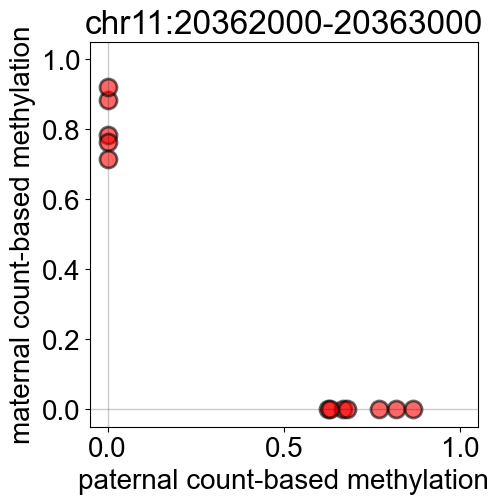

chr5:94915000-94916000
0.84 0.80 NA12877 chr5:94915000-94916000
0.71 0.78 NA12878 chr5:94915000-94916000
0.85 0.82 NA12887 chr5:94915000-94916000
0.65 0.71 NA12885 chr5:94915000-94916000
0.79 0.76 NA12883 chr5:94915000-94916000
0.96 0.75 NA12881 chr5:94915000-94916000
0.64 0.78 NA12879 chr5:94915000-94916000
0.71 0.84 NA12884 chr5:94915000-94916000
0.86 0.68 NA12882 chr5:94915000-94916000
0.67 0.73 200081 chr5:94915000-94916000
0.90 0.56 200082 chr5:94915000-94916000
0.81 0.67 200084 chr5:94915000-94916000
0.73 0.53 200085 chr5:94915000-94916000
0.75 0.62 200086 chr5:94915000-94916000
0.75 0.68 200087 chr5:94915000-94916000
0.75 0.00 200101 chr5:94915000-94916000
0.76 0.00 200102 chr5:94915000-94916000
0.82 0.00 200103 chr5:94915000-94916000
0.83 0.00 200104 chr5:94915000-94916000
0.76 0.00 200105 chr5:94915000-94916000
0.71 0.00 200106 chr5:94915000-94916000


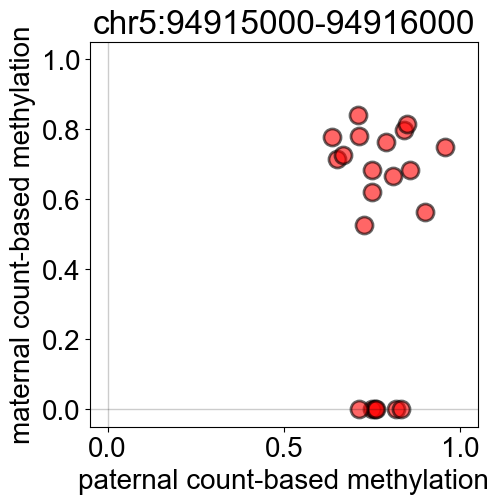

chr1:80405000-80406000
0.00 0.70 NA12878 chr1:80405000-80406000
0.00 0.74 NA12883 chr1:80405000-80406000
0.00 0.81 NA12886 chr1:80405000-80406000
0.00 0.73 NA12884 chr1:80405000-80406000
0.00 0.73 NA12882 chr1:80405000-80406000
0.71 0.00 200081 chr1:80405000-80406000
0.72 0.00 200084 chr1:80405000-80406000
0.64 0.00 200085 chr1:80405000-80406000
0.93 0.00 200087 chr1:80405000-80406000
0.88 0.00 200101 chr1:80405000-80406000
0.86 0.00 200102 chr1:80405000-80406000
0.60 0.00 200103 chr1:80405000-80406000


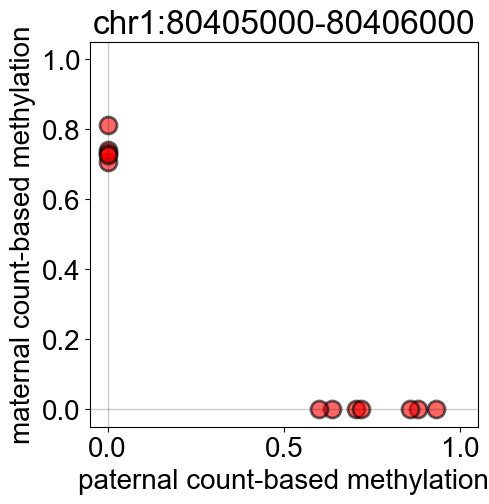

chr2:59622000-59623000
0.00 0.87 NA12877 chr2:59622000-59623000
0.00 0.76 NA12878 chr2:59622000-59623000
0.75 0.00 NA12887 chr2:59622000-59623000
0.00 0.72 NA12885 chr2:59622000-59623000
0.00 0.77 NA12883 chr2:59622000-59623000
0.00 0.85 NA12881 chr2:59622000-59623000
0.83 0.74 NA12879 chr2:59622000-59623000
0.00 0.75 NA12886 chr2:59622000-59623000
0.00 0.71 NA12882 chr2:59622000-59623000
0.94 0.71 200081 chr2:59622000-59623000
0.00 0.82 200082 chr2:59622000-59623000
0.00 0.84 200085 chr2:59622000-59623000
0.00 0.65 200086 chr2:59622000-59623000
0.83 0.84 200087 chr2:59622000-59623000
0.00 0.78 200101 chr2:59622000-59623000
0.90 0.00 200106 chr2:59622000-59623000


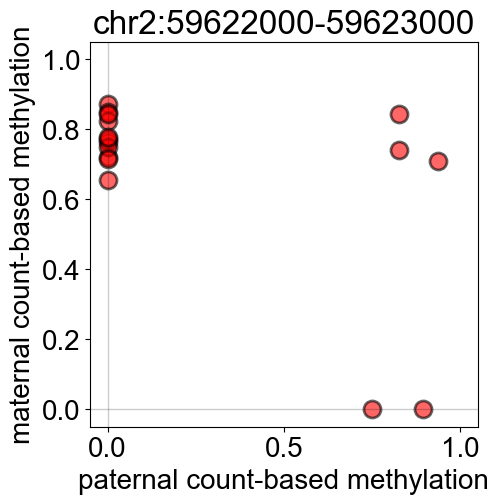

chr13:67944000-67945000
0.77 0.89 NA12877 chr13:67944000-67945000
0.89 0.00 NA12887 chr13:67944000-67945000
0.81 0.00 NA12885 chr13:67944000-67945000
0.82 0.00 NA12883 chr13:67944000-67945000
0.80 0.00 NA12881 chr13:67944000-67945000
0.82 0.00 NA12879 chr13:67944000-67945000
0.80 0.00 NA12886 chr13:67944000-67945000
0.87 0.00 NA12884 chr13:67944000-67945000
0.83 0.00 NA12882 chr13:67944000-67945000
0.00 0.83 200081 chr13:67944000-67945000
0.00 0.79 200084 chr13:67944000-67945000
0.00 0.90 200085 chr13:67944000-67945000
0.00 0.90 200086 chr13:67944000-67945000
0.00 0.84 200101 chr13:67944000-67945000
0.00 0.72 200103 chr13:67944000-67945000
0.71 0.62 200104 chr13:67944000-67945000
0.00 0.77 200105 chr13:67944000-67945000
0.00 0.91 200106 chr13:67944000-67945000


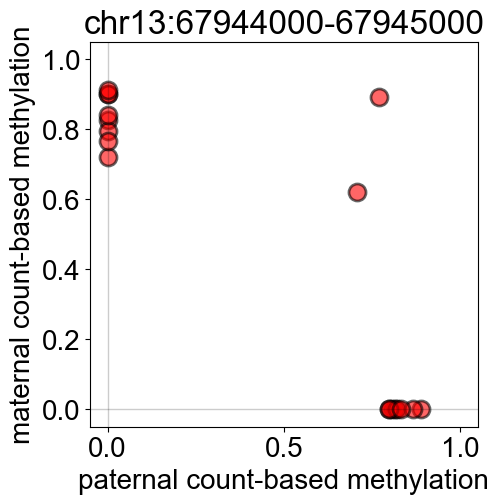

chr7:83799000-83800000
0.72 0.65 NA12877 chr7:83799000-83800000
0.73 0.71 NA12878 chr7:83799000-83800000
0.64 0.81 NA12887 chr7:83799000-83800000
0.71 0.70 NA12885 chr7:83799000-83800000
0.71 0.74 NA12883 chr7:83799000-83800000
0.73 0.71 NA12881 chr7:83799000-83800000
0.70 0.80 NA12879 chr7:83799000-83800000
0.76 0.73 NA12886 chr7:83799000-83800000
0.75 0.64 NA12884 chr7:83799000-83800000
0.81 0.73 NA12882 chr7:83799000-83800000
0.69 0.78 200081 chr7:83799000-83800000
0.76 0.76 200082 chr7:83799000-83800000
0.69 0.65 200084 chr7:83799000-83800000
0.72 0.79 200085 chr7:83799000-83800000
0.00 1.00 200101 chr7:83799000-83800000
0.69 0.73 200102 chr7:83799000-83800000
0.65 0.81 200103 chr7:83799000-83800000
0.59 0.76 200104 chr7:83799000-83800000
0.63 0.73 200106 chr7:83799000-83800000


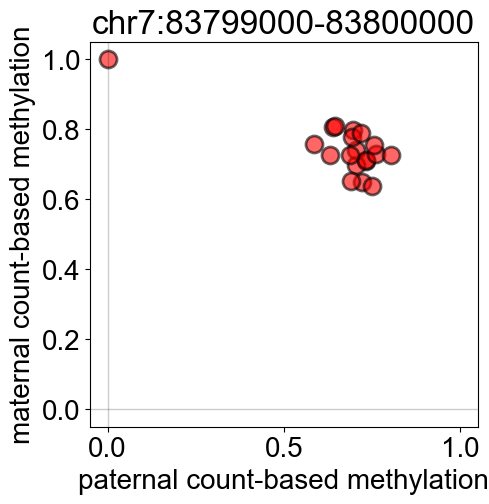

chr12:93558000-93559000
0.00 0.86 NA12877 chr12:93558000-93559000
0.96 0.00 NA12878 chr12:93558000-93559000
0.00 0.83 NA12885 chr12:93558000-93559000
0.00 0.89 NA12883 chr12:93558000-93559000
0.87 0.00 NA12879 chr12:93558000-93559000
0.00 0.70 NA12886 chr12:93558000-93559000
0.90 0.00 200082 chr12:93558000-93559000
0.00 0.82 200084 chr12:93558000-93559000
0.85 0.00 200102 chr12:93558000-93559000
0.71 0.00 200103 chr12:93558000-93559000
0.91 0.00 200105 chr12:93558000-93559000
0.87 0.00 200106 chr12:93558000-93559000


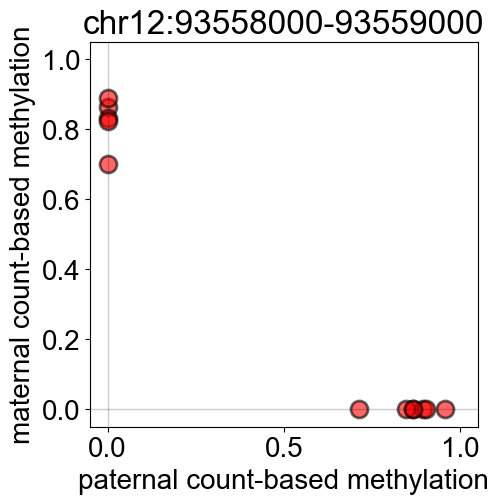

chr10:27080000-27081000
0.58 0.80 NA12877 chr10:27080000-27081000
0.00 0.64 NA12878 chr10:27080000-27081000
0.46 0.00 NA12887 chr10:27080000-27081000
0.82 0.00 NA12885 chr10:27080000-27081000
0.81 0.00 NA12883 chr10:27080000-27081000
0.69 0.00 NA12881 chr10:27080000-27081000
0.69 0.79 NA12879 chr10:27080000-27081000
0.54 0.00 NA12886 chr10:27080000-27081000
0.63 0.00 NA12884 chr10:27080000-27081000
0.62 0.56 NA12882 chr10:27080000-27081000
0.62 0.70 200081 chr10:27080000-27081000
0.78 0.85 200085 chr10:27080000-27081000
0.55 0.73 200087 chr10:27080000-27081000
0.63 0.57 200101 chr10:27080000-27081000
0.68 0.69 200102 chr10:27080000-27081000
0.65 0.55 200104 chr10:27080000-27081000
0.69 0.88 200105 chr10:27080000-27081000
0.00 0.68 200106 chr10:27080000-27081000


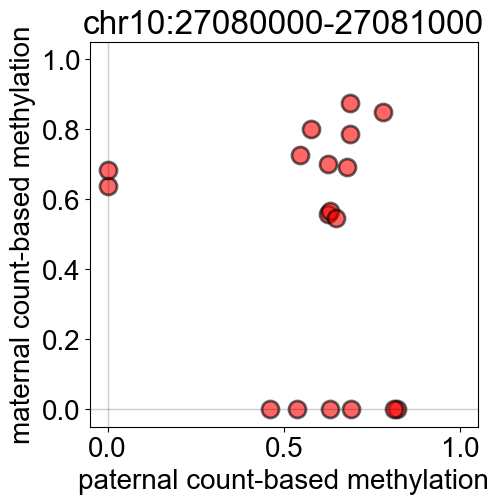

In [34]:
from get_palladium_prefixes import get_prefixes_wrapper

def plot_mat_vs_pat_meth(df, mode): 
    df = df.sample(8)
    for locus in df.iter_rows(named=True):
        chrom, start, end = locus['chrom'], locus['start'], locus['end']
        coordinate = f"{chrom}:{start}-{end}"
        print(coordinate)
        meths_pat, meths_mat, sample_ids = [], [], []
        for prefix in get_prefixes_wrapper():
            try:
                meths_pat.append(locus[f'{prefix}_{mode}_based_meth_pat'])
                meths_mat.append(locus[f'{prefix}_{mode}_based_meth_mat'])
                sample_ids.append(prefix)
            except KeyError: 
                continue

        for meth_pat, meth_mat, sample_id in zip(meths_pat, meths_mat, sample_ids): 
            if meth_pat is not None and meth_mat is not None: 
                print(f"{meth_pat:.2f}", f"{meth_mat:.2f}", sample_id, coordinate)

        plt.figure(figsize=(5,5))
        plt.scatter(
            meths_pat, 
            meths_mat,
            s=150,          
            marker='o',     
            edgecolor='black', 
            linewidths=2,   
            facecolor='red', 
            alpha=0.6   
        )
        plt.title(coordinate)
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
        plt.axvline(x=0, color='k', linestyle='-', linewidth=1, alpha=0.2)
        plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.2)
        plt.xlabel(f'paternal {mode}-based methylation')
        plt.ylabel(f'maternal {mode}-based methylation')
        plt.show()
        
plot_mat_vs_pat_meth(DF_METH_IMPRINTED_CANDIDATES, mode='count')

chr13:46280000-46281000
0.94 0.96 NA12877 chr13:46280000-46281000
0.90 0.95 NA12878 chr13:46280000-46281000
0.95 0.93 NA12887 chr13:46280000-46281000
0.94 0.95 200081 chr13:46280000-46281000
0.87 0.95 200082 chr13:46280000-46281000
0.95 0.90 200084 chr13:46280000-46281000
0.94 0.95 200085 chr13:46280000-46281000
0.94 0.95 200086 chr13:46280000-46281000
0.89 0.96 200087 chr13:46280000-46281000
0.94 0.05 200101 chr13:46280000-46281000
0.94 0.05 200102 chr13:46280000-46281000
0.94 0.06 200103 chr13:46280000-46281000
0.96 0.06 200104 chr13:46280000-46281000
0.94 0.05 200105 chr13:46280000-46281000
0.95 0.06 200106 chr13:46280000-46281000


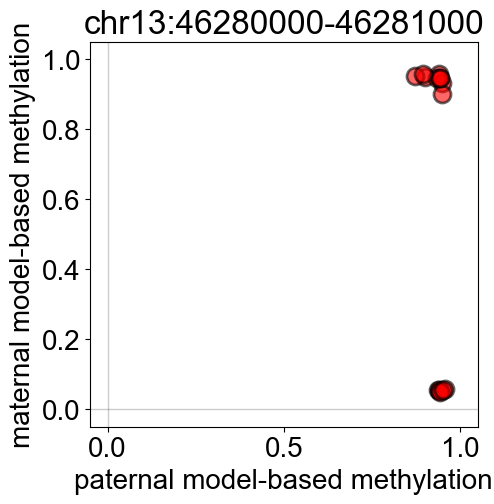

chr7:106479000-106480000
0.05 0.92 NA12877 chr7:106479000-106480000
0.95 0.94 NA12878 chr7:106479000-106480000
0.06 0.93 NA12885 chr7:106479000-106480000
0.05 0.91 NA12883 chr7:106479000-106480000
0.92 0.94 NA12881 chr7:106479000-106480000
0.07 0.96 NA12879 chr7:106479000-106480000
0.06 0.93 NA12886 chr7:106479000-106480000
0.04 0.96 NA12884 chr7:106479000-106480000
0.05 0.93 200101 chr7:106479000-106480000
0.95 0.92 200103 chr7:106479000-106480000
0.05 0.94 200104 chr7:106479000-106480000
0.95 0.94 200105 chr7:106479000-106480000


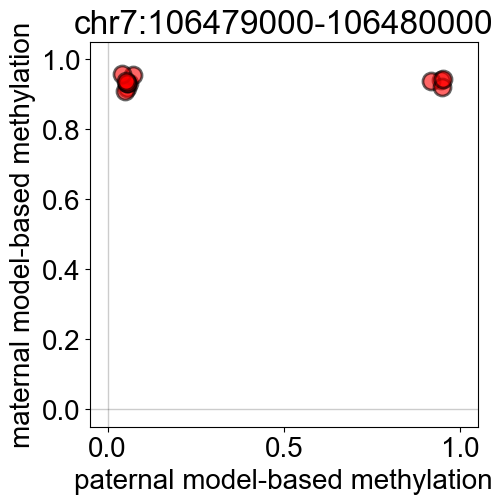

chr2:162998000-162999000
0.95 0.04 NA12877 chr2:162998000-162999000
0.95 0.05 NA12887 chr2:162998000-162999000
0.91 0.05 NA12885 chr2:162998000-162999000
0.89 0.04 NA12883 chr2:162998000-162999000
0.93 0.05 NA12879 chr2:162998000-162999000
0.88 0.05 NA12884 chr2:162998000-162999000
0.95 0.05 NA12882 chr2:162998000-162999000
0.87 0.06 200081 chr2:162998000-162999000
0.90 0.04 200082 chr2:162998000-162999000
0.88 0.91 200084 chr2:162998000-162999000
0.66 0.93 200086 chr2:162998000-162999000
0.95 0.94 200087 chr2:162998000-162999000
0.04 0.94 200101 chr2:162998000-162999000
0.05 0.90 200102 chr2:162998000-162999000
0.05 0.84 200103 chr2:162998000-162999000
0.06 0.94 200104 chr2:162998000-162999000
0.05 0.86 200105 chr2:162998000-162999000


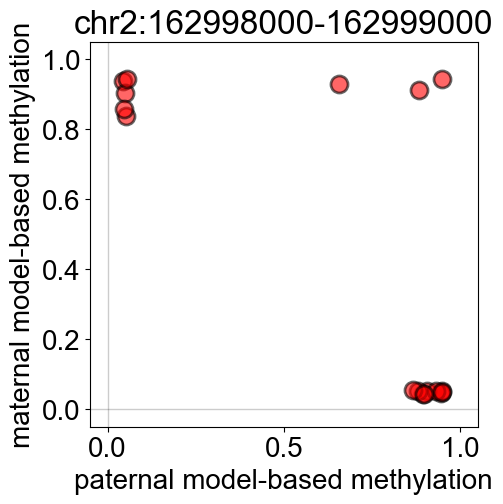

chr4:90902000-90903000
0.92 0.04 NA12878 chr4:90902000-90903000
0.05 0.80 NA12881 chr4:90902000-90903000
0.05 0.90 NA12879 chr4:90902000-90903000
0.04 0.84 NA12886 chr4:90902000-90903000
0.04 0.96 NA12884 chr4:90902000-90903000
0.04 0.86 NA12882 chr4:90902000-90903000
0.05 0.87 200082 chr4:90902000-90903000
0.04 0.62 200084 chr4:90902000-90903000
0.04 0.92 200085 chr4:90902000-90903000
0.06 0.95 200086 chr4:90902000-90903000
0.84 0.05 200102 chr4:90902000-90903000
0.95 0.06 200103 chr4:90902000-90903000
0.94 0.07 200105 chr4:90902000-90903000


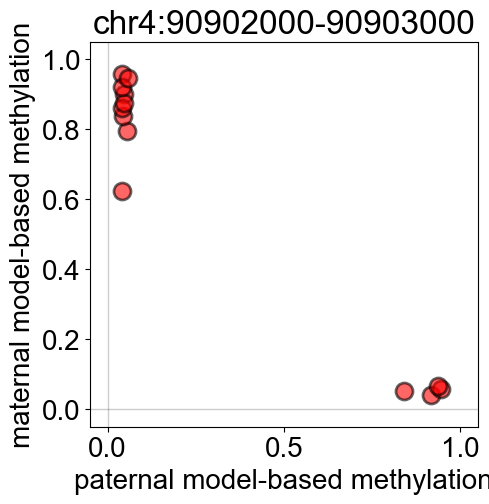

chr1:80049000-80050000
0.05 0.94 200102 chr1:80049000-80050000
0.06 0.94 200104 chr1:80049000-80050000
0.06 0.95 200106 chr1:80049000-80050000


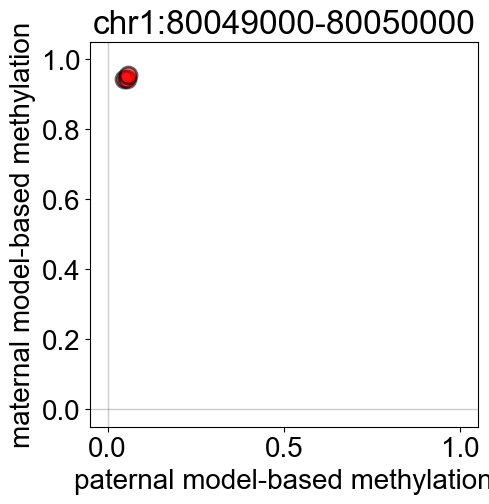

chr5:95998000-95999000
0.96 0.05 NA12877 chr5:95998000-95999000
0.93 0.94 NA12878 chr5:95998000-95999000
0.94 0.89 NA12885 chr5:95998000-95999000
0.96 0.96 NA12883 chr5:95998000-95999000
0.05 0.82 NA12879 chr5:95998000-95999000
0.95 0.90 NA12886 chr5:95998000-95999000
0.06 0.92 NA12884 chr5:95998000-95999000
0.06 0.96 NA12882 chr5:95998000-95999000
0.95 0.06 200081 chr5:95998000-95999000
0.96 0.06 200082 chr5:95998000-95999000
0.84 0.06 200084 chr5:95998000-95999000
0.96 0.04 200085 chr5:95998000-95999000
0.95 0.06 200086 chr5:95998000-95999000
0.95 0.95 200087 chr5:95998000-95999000
0.95 0.95 200101 chr5:95998000-95999000


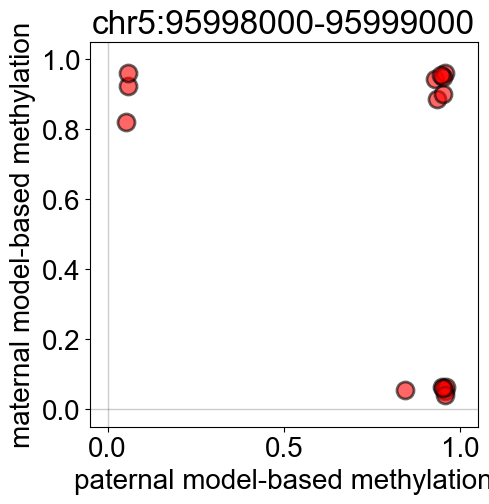

chr6:8428000-8429000
0.93 0.06 NA12878 chr6:8428000-8429000
0.05 0.97 NA12887 chr6:8428000-8429000
0.06 0.96 NA12885 chr6:8428000-8429000
0.06 0.96 NA12882 chr6:8428000-8429000
0.88 0.06 200081 chr6:8428000-8429000
0.95 0.06 200084 chr6:8428000-8429000
0.94 0.05 200085 chr6:8428000-8429000
0.90 0.06 200086 chr6:8428000-8429000
0.05 0.95 200101 chr6:8428000-8429000
0.06 0.92 200102 chr6:8428000-8429000
0.05 0.96 200103 chr6:8428000-8429000
0.04 0.96 200104 chr6:8428000-8429000
0.06 0.92 200105 chr6:8428000-8429000
0.06 0.96 200106 chr6:8428000-8429000


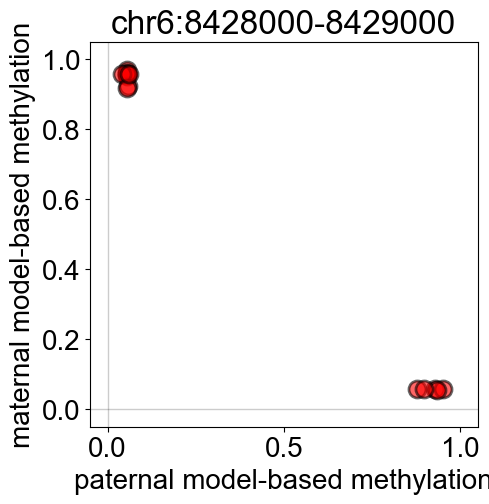

chr14:62233000-62234000
0.05 0.93 NA12878 chr14:62233000-62234000
0.06 0.95 NA12881 chr14:62233000-62234000
0.06 0.94 NA12886 chr14:62233000-62234000
0.94 0.07 200081 chr14:62233000-62234000
0.95 0.06 200082 chr14:62233000-62234000
0.95 0.05 200084 chr14:62233000-62234000
0.95 0.07 200085 chr14:62233000-62234000
0.95 0.05 200086 chr14:62233000-62234000
0.91 0.07 200087 chr14:62233000-62234000
0.05 0.81 200101 chr14:62233000-62234000
0.50 0.28 200102 chr14:62233000-62234000
0.49 0.13 200103 chr14:62233000-62234000
0.05 0.41 200104 chr14:62233000-62234000
0.50 0.37 200106 chr14:62233000-62234000


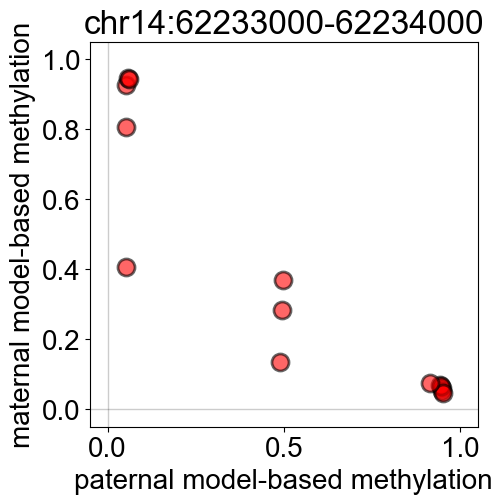

In [35]:
plot_mat_vs_pat_meth(DF_METH_IMPRINTED_CANDIDATES, mode='model')

chr7:23490000-23491000
0.18 0.89 NA12877 chr7:23490000-23491000
0.16 0.67 NA12878 chr7:23490000-23491000
0.16 0.60 NA12885 chr7:23490000-23491000
0.12 0.89 NA12882 chr7:23490000-23491000
0.18 0.24 200081 chr7:23490000-23491000
0.18 0.40 200082 chr7:23490000-23491000
0.19 0.91 200084 chr7:23490000-23491000
0.15 0.80 200085 chr7:23490000-23491000
0.16 0.86 200086 chr7:23490000-23491000
0.16 0.78 200087 chr7:23490000-23491000
0.16 0.86 200101 chr7:23490000-23491000
0.15 0.90 200102 chr7:23490000-23491000
0.18 0.84 200104 chr7:23490000-23491000
0.20 0.89 200105 chr7:23490000-23491000
0.15 0.81 200106 chr7:23490000-23491000


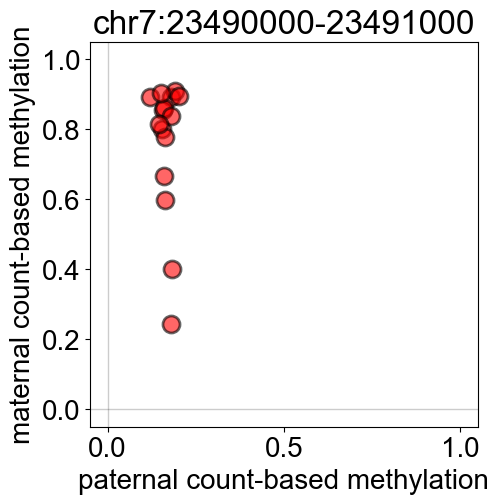

chr7:50782000-50783000
0.15 0.90 NA12878 chr7:50782000-50783000
0.16 0.90 NA12887 chr7:50782000-50783000
0.13 0.90 NA12885 chr7:50782000-50783000
0.18 0.88 NA12884 chr7:50782000-50783000
0.27 0.91 200081 chr7:50782000-50783000
0.24 0.83 200082 chr7:50782000-50783000
0.22 0.90 200084 chr7:50782000-50783000
0.20 0.88 200085 chr7:50782000-50783000
0.20 0.89 200087 chr7:50782000-50783000
0.19 0.88 200101 chr7:50782000-50783000
0.23 0.89 200102 chr7:50782000-50783000
0.18 0.88 200103 chr7:50782000-50783000
0.17 0.90 200104 chr7:50782000-50783000
0.19 0.90 200105 chr7:50782000-50783000


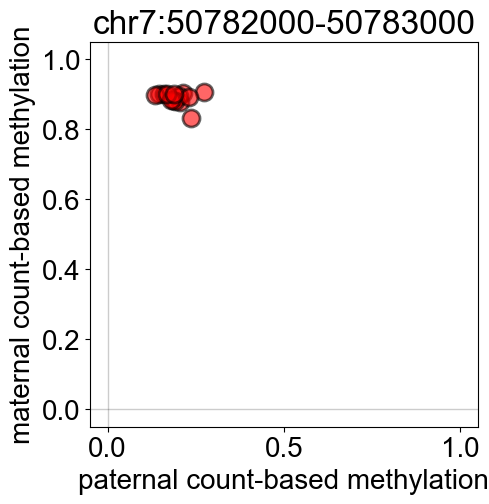

chr19:53554000-53555000
0.20 0.89 NA12877 chr19:53554000-53555000
0.39 0.54 NA12879 chr19:53554000-53555000
0.16 0.91 NA12886 chr19:53554000-53555000
0.20 0.92 NA12884 chr19:53554000-53555000
0.19 0.89 NA12882 chr19:53554000-53555000
0.22 0.88 200081 chr19:53554000-53555000
0.26 0.90 200084 chr19:53554000-53555000
0.23 0.90 200085 chr19:53554000-53555000
0.17 0.89 200101 chr19:53554000-53555000
0.18 0.90 200102 chr19:53554000-53555000
0.17 0.87 200103 chr19:53554000-53555000
0.22 0.87 200104 chr19:53554000-53555000
0.25 0.88 200105 chr19:53554000-53555000


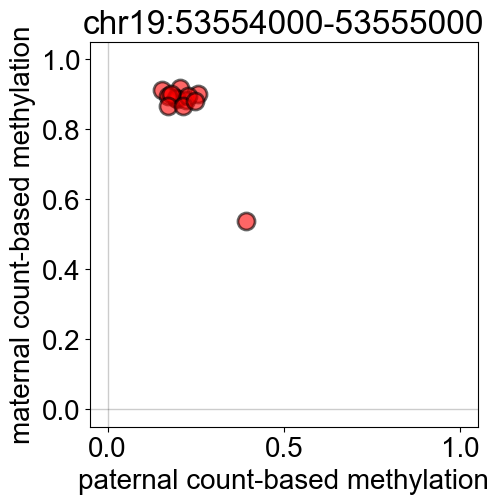

chr15:24956000-24957000
0.23 0.83 NA12877 chr15:24956000-24957000
0.17 0.81 NA12878 chr15:24956000-24957000
0.26 0.80 NA12887 chr15:24956000-24957000
0.20 0.78 NA12885 chr15:24956000-24957000
0.25 0.79 NA12883 chr15:24956000-24957000
0.17 0.80 NA12879 chr15:24956000-24957000
0.30 0.84 NA12886 chr15:24956000-24957000
0.26 0.86 NA12882 chr15:24956000-24957000
0.24 0.89 200081 chr15:24956000-24957000
0.26 0.84 200082 chr15:24956000-24957000
0.20 0.83 200084 chr15:24956000-24957000
0.20 0.82 200085 chr15:24956000-24957000
0.27 0.76 200087 chr15:24956000-24957000
0.20 0.85 200101 chr15:24956000-24957000
0.25 0.80 200102 chr15:24956000-24957000
0.24 0.82 200103 chr15:24956000-24957000
0.17 0.80 200104 chr15:24956000-24957000
0.26 0.80 200105 chr15:24956000-24957000
0.22 0.84 200106 chr15:24956000-24957000


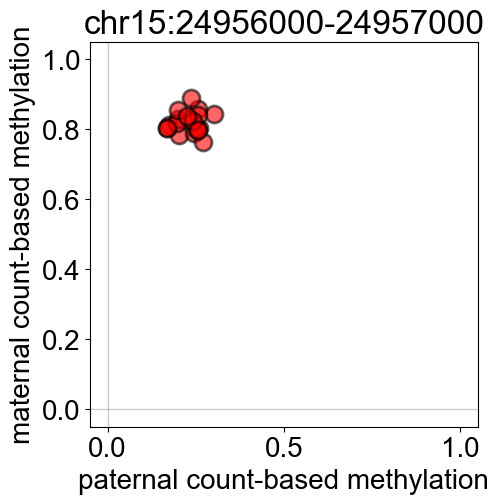

chr19:56839000-56840000
0.21 0.85 NA12877 chr19:56839000-56840000
0.23 0.83 NA12878 chr19:56839000-56840000
0.20 0.74 NA12887 chr19:56839000-56840000
0.22 0.85 NA12885 chr19:56839000-56840000
0.24 0.84 NA12883 chr19:56839000-56840000
0.17 0.78 NA12881 chr19:56839000-56840000
0.23 0.80 NA12879 chr19:56839000-56840000
0.27 0.80 NA12886 chr19:56839000-56840000
0.20 0.83 NA12884 chr19:56839000-56840000
0.21 0.81 NA12882 chr19:56839000-56840000
0.22 0.89 200081 chr19:56839000-56840000
0.25 0.82 200082 chr19:56839000-56840000
0.18 0.86 200084 chr19:56839000-56840000
0.22 0.84 200085 chr19:56839000-56840000
0.22 0.88 200086 chr19:56839000-56840000
0.23 0.80 200101 chr19:56839000-56840000
0.24 0.83 200102 chr19:56839000-56840000
0.29 0.84 200103 chr19:56839000-56840000
0.23 0.84 200104 chr19:56839000-56840000
0.23 0.76 200105 chr19:56839000-56840000
0.21 0.81 200106 chr19:56839000-56840000


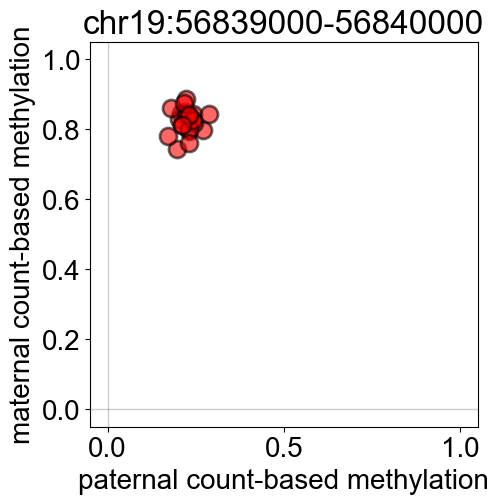

chr11:2699000-2700000
0.15 0.90 NA12877 chr11:2699000-2700000
0.13 0.89 NA12878 chr11:2699000-2700000
0.17 0.90 NA12887 chr11:2699000-2700000
0.16 0.86 NA12885 chr11:2699000-2700000
0.19 0.87 NA12883 chr11:2699000-2700000
0.15 0.88 NA12884 chr11:2699000-2700000
0.14 0.87 NA12882 chr11:2699000-2700000
0.17 0.88 200081 chr11:2699000-2700000
0.19 0.91 200082 chr11:2699000-2700000
0.18 0.87 200084 chr11:2699000-2700000
0.20 0.85 200085 chr11:2699000-2700000
0.17 0.87 200086 chr11:2699000-2700000
0.17 0.83 200087 chr11:2699000-2700000
0.18 0.87 200101 chr11:2699000-2700000
0.15 0.88 200103 chr11:2699000-2700000
0.17 0.86 200105 chr11:2699000-2700000
0.15 0.88 200106 chr11:2699000-2700000


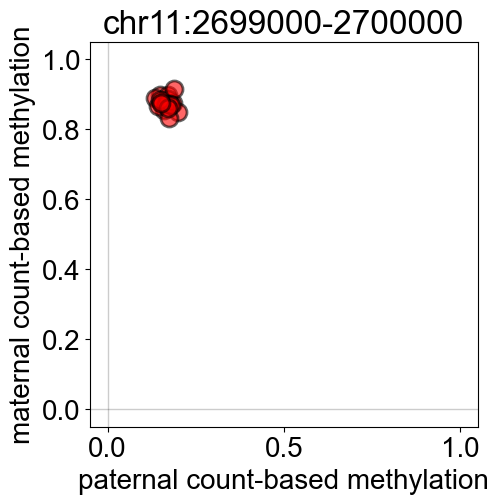

chr15:24955000-24956000
0.16 0.83 NA12877 chr15:24955000-24956000
0.14 0.84 NA12878 chr15:24955000-24956000
0.20 0.80 NA12887 chr15:24955000-24956000
0.15 0.80 NA12885 chr15:24955000-24956000
0.22 0.81 NA12883 chr15:24955000-24956000
0.18 0.80 NA12881 chr15:24955000-24956000
0.14 0.82 NA12879 chr15:24955000-24956000
0.21 0.84 NA12886 chr15:24955000-24956000
0.20 0.85 NA12884 chr15:24955000-24956000
0.20 0.81 NA12882 chr15:24955000-24956000
0.18 0.88 200081 chr15:24955000-24956000
0.19 0.86 200082 chr15:24955000-24956000
0.16 0.83 200084 chr15:24955000-24956000
0.14 0.81 200085 chr15:24955000-24956000
0.22 0.82 200087 chr15:24955000-24956000
0.15 0.87 200101 chr15:24955000-24956000
0.16 0.83 200102 chr15:24955000-24956000
0.20 0.83 200103 chr15:24955000-24956000
0.15 0.86 200104 chr15:24955000-24956000
0.18 0.82 200105 chr15:24955000-24956000
0.13 0.84 200106 chr15:24955000-24956000


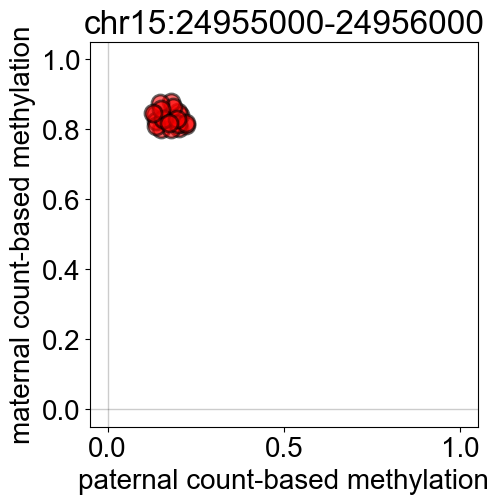

chr20:31547000-31548000
0.18 0.86 NA12877 chr20:31547000-31548000
0.17 0.88 NA12878 chr20:31547000-31548000
0.18 0.86 NA12887 chr20:31547000-31548000
0.22 0.86 NA12883 chr20:31547000-31548000
0.16 0.83 NA12881 chr20:31547000-31548000
0.13 0.84 NA12882 chr20:31547000-31548000
0.15 0.84 200081 chr20:31547000-31548000
0.22 0.86 200084 chr20:31547000-31548000
0.22 0.81 200086 chr20:31547000-31548000
0.13 0.86 200101 chr20:31547000-31548000
0.15 0.89 200102 chr20:31547000-31548000
0.14 0.82 200103 chr20:31547000-31548000


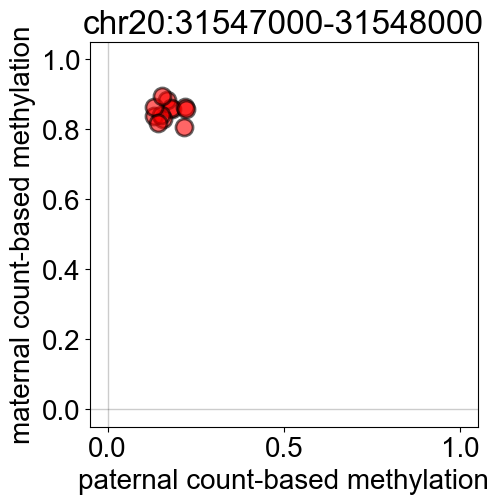

In [36]:
plot_mat_vs_pat_meth(
    DF_METH_IMPRINTED_CANDIDATES.join(DF_IMPRINTED_COMMON.select(['chrom', 'start', 'end']), on=['chrom', 'start', 'end'], how='inner'), 
    mode='count'
)